
GPT-4o Classification Results:
Filename: Fetal Brain Abnormalities Ultrasound.v1i.multiclass/test/Copy-of-mild-ventriculomegaly-18c_aug_2_png_jpg.rf.1a7978b80bec239d05c1870f509b7aaa.jpg
True Label: mild ventriculomegaly
Predicted Label: mild ventriculomegaly
Score: 5
Analysis: The ultrasound image shows a transverse section of the fetal brain. Key observations include:

1. **Lateral Ventricles**: There is a noticeable dilation of the lateral ventricles. The ventricles appear larger than normal but not excessively so.

2. **Cavum Septum Pellucidum**: While not fully visible, the structure appears somewhat present, which may suggest normal midline development.

3. **Cortical Structures**: The cortical structures appear to be developing but are not clearly demarcated in this image. There are no areas of severe malformation or asymmetry visible.

4. **Posterior Fossa**: This area is not well visualized in the image, preventing detailed analysis of structures like the cerebellum and cister

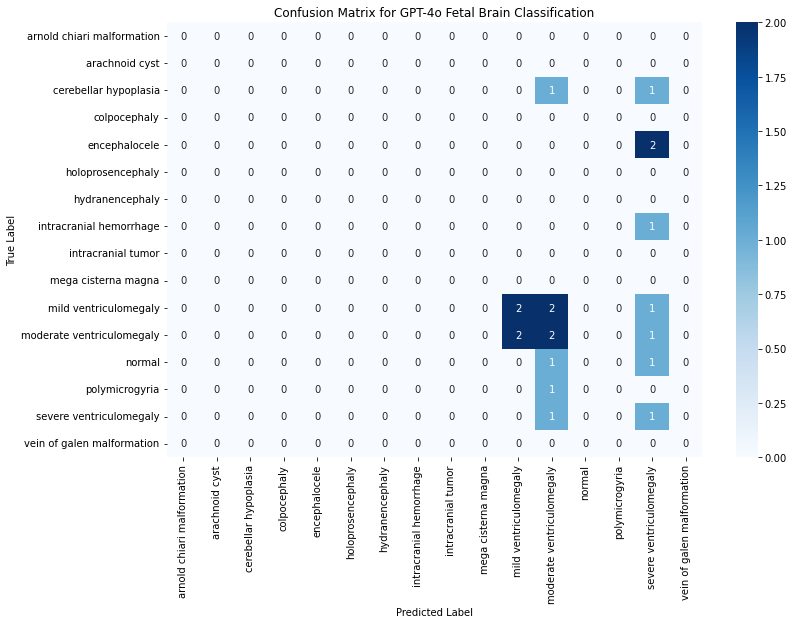

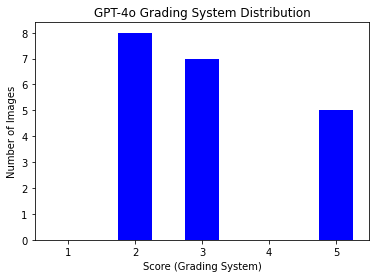

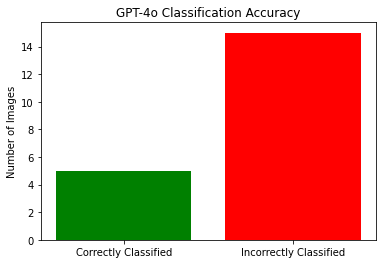

In [24]:
import openai
import base64
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# OpenAI API Key
openai.api_key = "-"

# List of valid classification labels
VALID_CONDITIONS = [
    "arnold chiari malformation", "arachnoid cyst", "cerebellar hypoplasia", "colpocephaly",
    "encephalocele", "holoprosencephaly", "hydranencephaly", "intracranial hemorrhage",
    "intracranial tumor", "mega cisterna magna", "mild ventriculomegaly", "moderate ventriculomegaly",
    "normal", "polymicrogyria", "severe ventriculomegaly", "vein of galen malformation"
]

def encode_image(image_path):
    """ Convert an image to base64 encoding for OpenAI Vision API. """
    if not os.path.exists(image_path):
        print(f"Warning: Missing image {image_path}")
        return None
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def analyze_ultrasound(image_path):
    """ Analyzes a fetal brain ultrasound image with GPT-4o. """
    image_base64 = encode_image(image_path)
    if image_base64 is None:
        return None

    try:
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": (
                    "You are an AI specializing in fetal brain ultrasound analysis. "
                    "Analyze the image and describe key structural and fluid-related features. "
                    "Then, classify the image into exactly one of the following conditions: " + ", ".join(VALID_CONDITIONS) + ". "
                    "**Ensure you provide a detailed analysis before stating the final classification.** "
                    "At the very end, explicitly state the classification in this format:\n\n"
                    "**Final Classification: [exact condition]**\n\n"
                )},
                {"role": "user", "content": [
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}}
                ]}
            ],
            max_tokens=500
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error calling GPT-4o API: {e}")
        return None

def extract_final_classification(analysis_report):
    """ Extracts the final classification from GPT-4o's response. """
    if not analysis_report:
        return "unknown"

    lines = analysis_report.strip().split("\n")
    for line in reversed(lines):
        line = line.strip().lower()
        if "final classification:" in line:
            pred_label = line.split("final classification:")[-1].strip()
            pred_label = re.sub(r"[^\w\s]", "", pred_label).lower()
            return pred_label if pred_label in VALID_CONDITIONS else "unknown"
    return "unknown"

def assign_grade(true_label, predicted_label, analysis):
    """ Assigns a score based on classification correctness and justification. """
    true_label = true_label.lower()
    predicted_label = predicted_label.lower()

    if predicted_label == true_label:
        if "ventricle" in analysis.lower() or "brain structure" in analysis.lower():
            return 5  # Strong justification using key features
        return 4  # Correct classification but missing justification

    elif ("ventriculomegaly" in predicted_label and "ventriculomegaly" in true_label) or \
         ("hypoplasia" in predicted_label and "hypoplasia" in true_label) or \
         ("tumor" in predicted_label and "tumor" in true_label):
        return 3  # Misclassified but closely related condition

    elif predicted_label == "unknown":
        return 1  # No useful classification provided

    else:
        return 2  # Incorrect classification but somewhat relevant description

def evaluate_gpt4o(dataset_path):
    """ Evaluates GPT-4o performance on a dataset of images with ground truth labels. """
    results = []
    
    # Load dataset (image filenames and one-hot encoded labels)
    dataset = pd.read_csv(dataset_path, encoding="utf-8", on_bad_lines='skip')
    dataset['ground_truth'] = dataset.iloc[:, 1:].idxmax(axis=1).str.replace('_', ' ')

    # Process first 20 images for testing
    for _, row in dataset.head(20).iterrows():
        image_path = os.path.join("Fetal Brain Abnormalities Ultrasound.v1i.multiclass", "test", row['filename'])
        true_label = row['ground_truth']
        if os.path.exists(image_path):
            analysis_report = analyze_ultrasound(image_path)
            pred_label = extract_final_classification(analysis_report)
            score = assign_grade(true_label, pred_label, analysis_report)
            results.append({"image": image_path, "true_label": true_label, "predicted_label": pred_label, "score": score, "analysis": analysis_report})
        else:
            print(f"Skipping missing image: {image_path}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    results_df.to_csv("gpt4o_ultrasound_results.csv", index=False)

    # Print results
    print("\nGPT-4o Classification Results:")
    for _, row in results_df.iterrows():
        print(f"Filename: {row['image']}")
        print(f"True Label: {row['true_label']}")
        print(f"Predicted Label: {row['predicted_label']}")
        print(f"Score: {row['score']}")
        print(f"Analysis: {row['analysis']}")
        print("-" * 80)

    # Classification Report
    y_true = results_df['true_label'].str.lower()
    y_pred = results_df['predicted_label'].str.lower()
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, labels=VALID_CONDITIONS, zero_division=1))

    # Compute Overall Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=VALID_CONDITIONS)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=VALID_CONDITIONS, yticklabels=VALID_CONDITIONS)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for GPT-4o Fetal Brain Classification")
    plt.show()

    # Grading System Bar Graph (Ensure all 1-5 scores appear)
    score_counts = results_df['score'].value_counts().reindex([1, 2, 3, 4, 5], fill_value=0)
    plt.figure(figsize=(6, 4))
    score_counts.plot(kind='bar', color='blue')
    plt.xlabel("Score (Grading System)")
    plt.ylabel("Number of Images")
    plt.title("GPT-4o Grading System Distribution")
    plt.xticks(rotation=0)
    plt.show()

    # Correct vs Incorrect Classification
    correct_classifications = (y_true == y_pred).sum()
    incorrect_classifications = len(results_df) - correct_classifications
    plt.figure(figsize=(6, 4))
    plt.bar(["Correctly Classified", "Incorrectly Classified"], [correct_classifications, incorrect_classifications], color=['green', 'red'])
    plt.ylabel('Number of Images')
    plt.title('GPT-4o Classification Accuracy')
    plt.xticks(rotation=0)
    plt.show()

# Run evaluation
dataset_path = os.path.join("Fetal Brain Abnormalities Ultrasound.v1i.multiclass", "test", "_classes - _classes.csv")
if os.path.exists(dataset_path):
    evaluate_gpt4o(dataset_path)
else:
    print("Dataset file not found! Ensure you provide a valid CSV.")
